<a href="https://colab.research.google.com/github/hemu2014/python-ML/blob/main/%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0-RNNdocs-%E6%AD%A3%E5%BC%8F/tutorials/text_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar() #调用tfds.disable_progress_bar()函数来禁用TensorFlow Datasets的下载或加载数据时显示的进度条。

In [ ]:
print(tf.__version__)

2.18.0


Import `matplotlib` and create a helper function to plot graphs:

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

###设置输入流水线

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec  #查看训练集的数据结构（即每个样本的输入和标签的 Tensor 类型和形状）。

'''
每个样本是一个元组 (text, label)。
text 是字符串类型的影评（dtype=tf.string）。
label 是整型标签（0 或 1，对应负面/正面评价，dtype=tf.int64）。

'''

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


'\n每个样本是一个元组 (text, label)。\ntext 是字符串类型的影评（dtype=tf.string）。\nlabel 是整型标签（0 或 1，对应负面/正面评价，dtype=tf.int64）。\n\n'

In [4]:
info.features['text']

Text(shape=(), dtype=string)

In [5]:
print(info.description)

Large Movie Review Dataset. This is a dataset for binary sentiment
classification containing substantially more data than previous benchmark
datasets. We provide a set of 25,000 highly polar movie reviews for training,
and 25,000 for testing. There is additional unlabeled data for use as well.


In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_e

In [ ]:
print(type(train_dataset))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


Initially this returns a dataset of (text, label pairs):

take(1) 的含义
作用：从数据集中提取前1个元素（注意是元素，不是批次）。

关键点：

* take(N) 是按样本数量（而非批次数量）操作的。

* 如果数据集是未分批次的（即每个元素是单个样本），take(1) 就返回1条数据。

* 如果数据集已分批次（如 batch(32)），take(1) 会返回1个批次（含32条数据）。

In [6]:
for example, label in train_dataset.take(3):
  print('text: ', example.numpy()) #文本会以字节形式（b'...'）显示。
  print('text: ', example.numpy().decode('utf-8')) #如需显示普通字符串
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
text:  This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an earl

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
'''
.prefetch(tf.data.AUTOTUNE)
作用：异步预取数据，即在模型训练当前批次时，后台提前加载下一批次数据。
参数：tf.data.AUTOTUNE：由TensorFlow自动选择最优的预取缓冲区大小。
为什么需要：避免数据加载成为训练瓶颈（即GPU等模型计算设备无需等待数据加载）。
'''

'\n.prefetch(tf.data.AUTOTUNE)\n作用：异步预取数据，即在模型训练当前批次时，后台提前加载下一批次数据。\n参数：tf.data.AUTOTUNE：由TensorFlow自动选择最优的预取缓冲区大小。\n为什么需要：避免数据加载成为训练瓶颈（即GPU等模型计算设备无需等待数据加载）。\n'

### 取前三个数据，**已经分批次了**

In [14]:
for example, label in train_dataset.take(1):
  print(len(label.numpy()))
  for i in range(3):
    print('text: ', example.numpy()[i]) #文本会以字节形式（b'...'）显示。
    print('text: ', example.numpy()[i].decode('utf-8')) #如需显示普通字符串
    print('label: ', label.numpy()[i])

64
text:  b'This is unlike any other movie, the closest thing I can compare it to is a Woody Allen film... But where as Woody Allen is constantly fathoming human foibles Bret Carr appears to be trying to figure out a way to get to grips with that one crippling insecurity that tends to define us for better or worse. In the Case of Lou, it is the root cause of his stuttering, which can be traced back to a singular child hood trauma that is revealed through flash backs.<br /><br />There are so many strangely neurotic people in the world and I believe they all deserve a chance for redemption, although diversity of human character is after all what makes the world such an intriguing place, so maybe we shouldn\'t fix our neurosis anymore than we should fix our noses or Breasts.<br /><br />This is an indie film shot on a long shoestring, but the production values are tremendous as is the scope of the film. I feel like its a quirky Gem for the self-help market. I really look forward to seeing 

### 取的时候应该是随机的，因为清洗，shuffle

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print(type(example.numpy()[:3]))
  print('labels: ', label.numpy()[:3])

texts:  [b'I wasn\'t as "lucky" as some of the others commenting on this film: i have never seen anything else out of the...shall we say... "fecund" mind of Sarno. I agree with many: some of the actresses who spend a lot of time topless and (go-go) dancing are not really that attractive. I kinda liked Fraulein Crank(?)...she was so homely , she was cute! The acting was pretty stale, also, though delivering lines in a second language might have accounted for a lot of that problem. Trying to follow the plot was a major chore: was there one, really? I do heartily agree with one other comment: for a vampire movie, there\'s not much blood. Yep, if you want GOOD bloodsucking flicks, check out such Hammer classics as "Horror of Dracula" and (my personal favourite) "Brides of Dracula".<br /><br />The most (unintentionally) humorous part is where the lady doctor gets her clothes torn off by a cloud of bats...which you never SEE!...the bats, I mean.<br /><br />Okay as a time-waster if you happen

In [ ]:
#import tensorflow as tf

# 模拟数据集
data = tf.data.Dataset.from_tensor_slices(list("ABCDEFGHIJ"))
# 设置小缓冲区观察行为
shuffled = data.shuffle(buffer_size=3).batch(3)

# 查看输出顺序
for item in shuffled.take(4): # 取10次观察重复情况

  print(item.numpy())

[b'A' b'B' b'D']
[b'E' b'G' b'H']
[b'F' b'J' b'C']
[b'I']


## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
#从训练集中提取文本部分（丢弃标签 label），生成一个仅包含文本的新数据集。
encoder.adapt(train_dataset.map(lambda text, label: text)) #遍历所有文本，统计词频并构建词汇表（选择前 VOCAB_SIZE 个高频词）。
# 测试集/验证集不需要再次 adapt()（应使用相同的词汇表）。

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [10]:
vocab = np.array(encoder.get_vocabulary()) # 获取的词汇表转为numpy数组
print(vocab[:20])
vocab_test = vocab[:20]
# 检查特定词的索引
word = ['movie']
print(vocab_test == word) #将词汇表中的每个元素与 word 比较，返回一个布尔数组（True/False）。
# 类似(array([4]),)  # 注意是元组，包含一个NumPy数组 [4]
print(np.where(vocab == word))# 返回满足条件（True）的元素的 索引位置。返回一个元组（即使是一维数组，也会包装成元组）。
# 第一个0是取元组的第一个元素得到一个数组， 第二个0访问数组的索引为0的数据
print(np.where(vocab == word)[0][0])
if word in vocab:
    print(f"Index of '{word}':", np.where(vocab == word)[0][0])
else:
    print(f"'{word}' is out of vocabulary!")

['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was' 'as' 'for' 'with' 'movie' 'but']
[False False False False False False False False False False False False
 False False False False False False  True False]
(array([18]),)
18
Index of '['movie']': 18


###查找多个单词索引

In [ ]:
vocab = np.array(encoder.get_vocabulary()) # 获取的词汇表转为numpy数组
print(vocab[:20])
vocab_test = vocab[:20]
# 检查特定词的索引
word = ['movie', 'but']
# Use np.isin() to check if elements of 'word' are in 'vocab_test'
print(np.isin(vocab_test, word)) # This will return a boolean array
# Use np.where() with np.isin() to find the indices
print(np.where(np.isin(vocab, word))) # This will return the indices of 'word' elements in 'vocab'
# Loop through the words and check if they're in the vocabulary
for w in word:
    if w in vocab:
        print(f"Index of '{w}':", np.where(vocab == w)[0][0])
    else:
        print(f"'{w}' is out of vocabulary!")

['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was' 'as' 'for' 'with' 'movie' 'but']
[False False False False False False False False False False False False
 False False False False False False  True  True]
(array([18, 19]),)
Index of 'movie': 18
Index of 'but': 19


###构建字典查询

In [ ]:
# 假设 vocab 是 NumPy 数组
vocab_3 = np.array(['', '[UNK]', 'the', 'and', 'movie', 'this'])
words = ["movie", "the", "unknown_word", "this"]

# 构建字典
vocab_dict = {word: idx for idx, word in enumerate(vocab_3)}
print(vocab_dict)
# 批量查找
indices = [vocab_dict.get(word, 1) for word in words]
print("单词索引:", indices)  # 输出: [4, 2, 1, 5]

# 反向查询（索引→单词）
words_found = vocab_3[indices] # 通过索引列表，去反向访问单词
print("对应单词:", words_found)  # 输出: ['movie' 'the' '[UNK]' 'this']

{np.str_(''): 0, np.str_('[UNK]'): 1, np.str_('the'): 2, np.str_('and'): 3, np.str_('movie'): 4, np.str_('this'): 5}
单词索引: [4, 2, 1, 5]
对应单词: ['movie' 'the' '[UNK]' 'this']


Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

####encoder(example) 的运作
encoder(example)
作用：调用之前适配（adapt）过的 TextVectorization 层，将文本转换为 词索引序列。

内部流程：

* 标准化文本：自动转为小写、去除标点（根据 encoder 的配置）。

* 分词：按空格拆分成单词列表（如 ["i", "love", "this", "movie"]）。

* 词到索引映射：根据词汇表将每个词转换为对应的整数索引。

* 若词在词汇表中 → 返回索引（如 "movie" → 4）。

* 若词不在词汇表中 → 返回 [UNK] 的索引（默认是 1）。

输出格式：返回一个 tf.Tensor，形状为 (序列长度,)，例如：

* tf.Tensor([10, 25, 3, 4], shape=(4,), dtype=int64)  # 假设的映射结果

In [16]:
encoded_example = encoder(example)[:3].numpy()
print(encoder(example).shape)
print(encoder(example)[:3].shape)
print(encoded_example.shape)
print(len(example), type(example))
#print(len(encoded_example[0]),encoded_example[0])
encoded_example

(64, 987)
(3, 987)
(3, 987)
64 <class 'tensorflow.python.framework.ops.EagerTensor'>


array([[ 11,   7, 994, ...,   0,   0,   0],
       [  1,   7, 154, ...,   0,   0,   0],
       [  4,   1,   1, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [17]:
encoder(example)[0][0]

<tf.Tensor: shape=(), dtype=int64, numpy=11>

In [20]:
example[0].numpy()[2]

105

In [ ]:
vocab[encoded_example[0][:10]] # 前10个字符

array(['i', '[UNK]', 'for', 'this', 'movie', 'for', 'years', 'apparently',
       'it', '[UNK]'], dtype='<U14')

In [ ]:
print(type(vocab))

<class 'numpy.ndarray'>


In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  # 打印编码-解码后的文本（通过词汇表 vocab 转换回单词）。
  print("Round-trip: ", " ".join(vocab[encoded_example[n]])) #encoded_example[n]是一个索引数组
  # " ".join(...)	将单词列表还原为连贯文本。
  print()

Original:  b"I searched for this movie for years, apparently it ain't available here in the States so bought me a copy off Ebay.<br /><br />Four young hunters and three of their girlfriends venture into the woods searching for a bear that apparently has killed several campers. What they find is an ex-Vietnam vet gone crazy (he kills some of his victims using a glove with long metal finger nails a la Freddy Krueger). As soon as the night falls, one of the girls goes for a walk after a brief argument with her boyfriend, she gets killed. After one of the group finds her body, they all hide in their tents waiting for daylight. Once the sun comes up, all of them try and make it out, but fall victim one by one.<br /><br />Seven bodies, not a lot of gore, but a couple of good murders, especially the girls'deaths. The guys get killed in somewhat bloodless ways (blown up in car, shot to death, knife through head). <br /><br />Overall, INFERNAL TRAP is a nice slasher film from the late 80's. Not

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder, # 数据集
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_cocabulary()),
        out_dim=64,
        #这对于处理可变长度的序列非常重要。它告诉层在处理过程中忽略填充标记
        #（用 0 表示）。填充通常用于使所有输入序列长度相同。
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

 '''
 此代码定义了一个使用双向 LSTM 分析文本并预测其情感的文本分类模型。该模型使用 Keras 构建，包含一个嵌入层将单词表示为向量，
 密集层进行额外处理，以及一个输出层提供最终的感性预测。
 '''

In [21]:
model = tf.keras.Sequential([
    encoder,  #
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

####这可以让您知道模型中哪些层能够处理掩码输入（在处理具有可变长度的数据序列时通常需要）。
* 想象你有一组不同长度的句子。为了使它们的长度相同，你需要在较短的句子中添加填充。掩码就像一组指令，告诉模型：“不要关注填充，专注于句子中的实际单词。”
* 通过忽略无关的填充标记，模型可以更有效地从输入数据的有效部分学习，从而提高准确率。
*高效训练：掩码有助于防止在填充标记上进行不必要的计算，使训练过程更快更高效。
* 该代码行 print([layer.supports_masking for layer in model.layers]) 很重要，因为它检查您的模型中的层是否能够利用此掩码机制。这确保了您的模型能够正确处理可变长度的序列，并从实际数据而不是填充数据中有效地学习。

In [22]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text], dtype=tf.string))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[0.01619262]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [25]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(tf.constant([sample_text, padding], dtype=tf.string))
#print(predictions)
print(predictions[0]) #多行文本不影响他的概率， 注意数据数据格式，显示转为张量

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
[0.01619262]


Compile the Keras model to configure the training process:

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [27]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 730s 2s/step - accuracy: 0.5062 - loss: 0.6870 - val_accuracy: 0.6917 - val_loss: 0.5651
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 743s 2s/step - accuracy: 0.7790 - loss: 0.4799 - val_accuracy: 0.8083 - val_loss: 0.3901
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 712s 2s/step - accuracy: 0.8458 - loss: 0.3580 - val_accuracy: 0.8391 - val_loss: 0.3593
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 710s 2s/step - accuracy: 0.8592 - loss: 0.3347 - val_accuracy: 0.8568 - val_loss: 0.3377
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - accuracy: 0.8633 - loss: 0.3220 - val_accuracy: 0.8510 - val_loss: 0.3569


In [28]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 152s 388ms/step - accuracy: 0.8560 - loss: 0.3532
Test Loss: 0.35027891397476196
Test Accuracy: 0.857200026512146


(0.0, 0.6743337124586105)

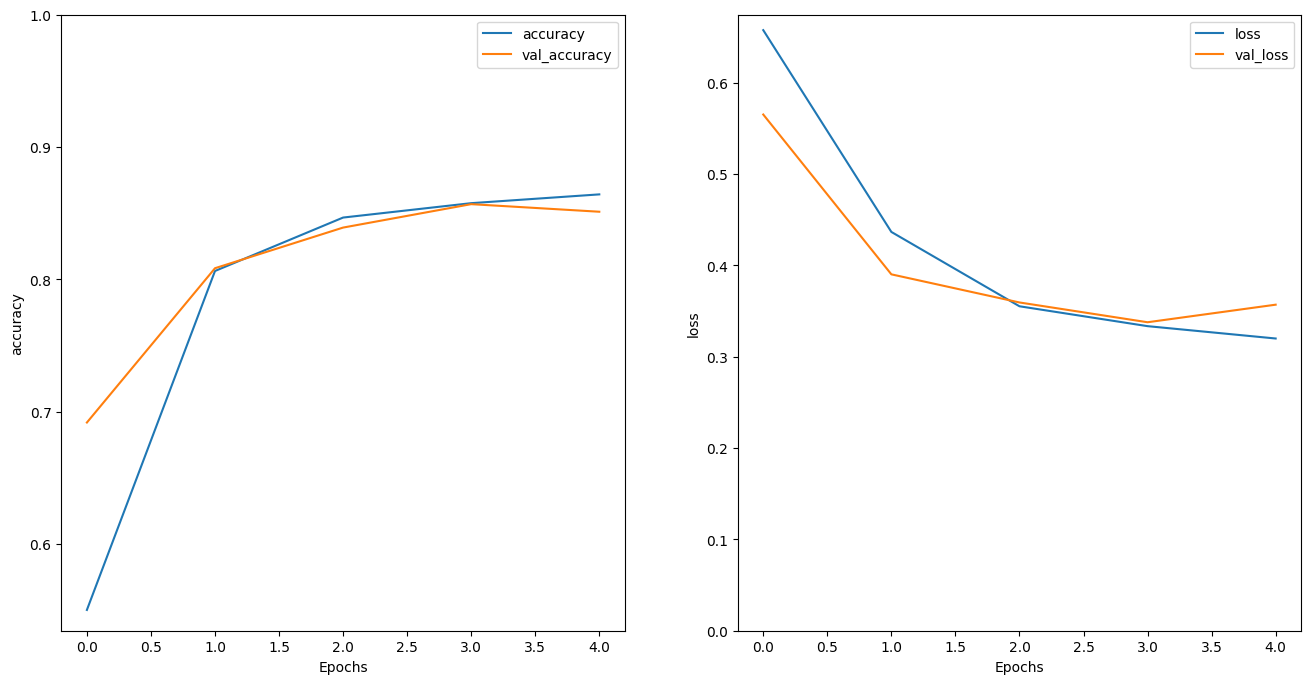

In [29]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

####2. Logits与概率的转换
Logits：
模型直接输出的值（范围
(
−
∞
,
+
∞
)
(−∞,+∞)），未经过sigmoid压缩。

Sigmoid函数：
将logits映射到 [0, 1] 的概率区间：
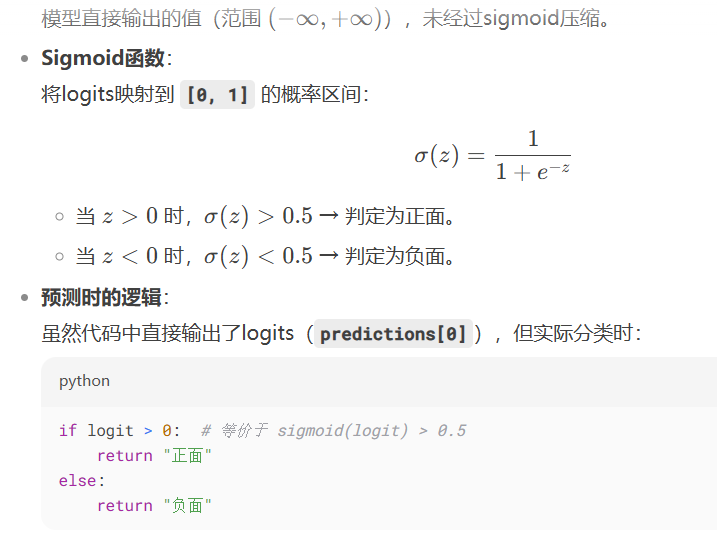




In [30]:


# 查看训练过程中的损失和准确率
print("训练历史:", history.history)


训练历史: {'accuracy': [0.5499600172042847, 0.8062400221824646, 0.8466399908065796, 0.8575199842453003, 0.8641600012779236], 'loss': [0.6574556827545166, 0.43655604124069214, 0.355171799659729, 0.33341121673583984, 0.31989508867263794], 'val_accuracy': [0.6916666626930237, 0.8083333373069763, 0.839062511920929, 0.8567708134651184, 0.8510416746139526], 'val_loss': [0.5650916695594788, 0.3901327848434448, 0.3593432605266571, 0.3376866281032562, 0.3569154739379883]}


In [31]:
# 测试训练后的模型
for text_batch, label_batch in train_dataset.take(1):
    print(text_batch[0], type(text_batch[0]))
    print(text_batch[0].shape)
    print(len(text_batch))
    print(type(text_batch), text_batch.shape)
    predictions = model.predict(text_batch)
    print(predictions.shape)
    print(predictions[0], predictions[0].shape)
    print(tf.sigmoid(predictions[:5]).numpy())  # 查看前5个预测结果
    print(tf.sigmoid(predictions[:5]).numpy().shape)

tf.Tensor(b'<br /><br />I watched this movie just a little while ago and I found that this movie was terrible! It moved very slowly and was hardly entertaining!<br /><br />Sorry for all those that liked it.... this is only my opinion!', shape=(), dtype=string) <class 'tensorflow.python.framework.ops.EagerTensor'>
()
64
<class 'tensorflow.python.framework.ops.EagerTensor'> (64,)
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
(64, 1)
[-1.0008882] (1,)
[[0.26876682]
 [0.56207687]
 [0.94670796]
 [0.9303376 ]
 [0.73373467]]
(5, 1)


In [33]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
print([sample_text])
print(type([sample_text]))
print(tf.constant([sample_text], dtype=tf.string).shape)
print(type(tf.constant([sample_text], dtype=tf.string)))
predictions = model.predict(tf.constant([sample_text], dtype=tf.string))
print(predictions)
print(predictions[0])

['The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.']
<class 'list'>
(1,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
[[0.7586971]]
[0.7586971]


In [38]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
sample_text_2 = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(tf.constant([sample_text,sample_text_2], dtype=tf.string))
print(predictions) # 两个预测的数据
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[ 0.75869733]
 [-1.0467671 ]]
[0.75869733]


In [40]:
sample = np.array(["The movie was great!", 'dfdfd'])
sample.shape

(2,)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [41]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [42]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [43]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1356s 3s/step - accuracy: 0.5112 - loss: 0.6849 - val_accuracy: 0.7578 - val_loss: 0.4572
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1353s 3s/step - accuracy: 0.8159 - loss: 0.4066 - val_accuracy: 0.8448 - val_loss: 0.3447
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1357s 3s/step - accuracy: 0.8520 - loss: 0.3461 - val_accuracy: 0.8484 - val_loss: 0.3329
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1402s 4s/step - accuracy: 0.8581 - loss: 0.3309 - val_accuracy: 0.8208 - val_loss: 0.3503
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1401s 4s/step - accuracy: 0.8613 - loss: 0.3167 - val_accuracy: 0.8542 - val_loss: 0.3221


In [44]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 273s 697ms/step - accuracy: 0.8603 - loss: 0.3160
Test Loss: 0.3138206899166107
Test Accuracy: 0.8614400029182434


In [46]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[-1.8602009]]


In [49]:
model.save('rnn_model.keras')

In [48]:
model.save('rnn_model.h5')

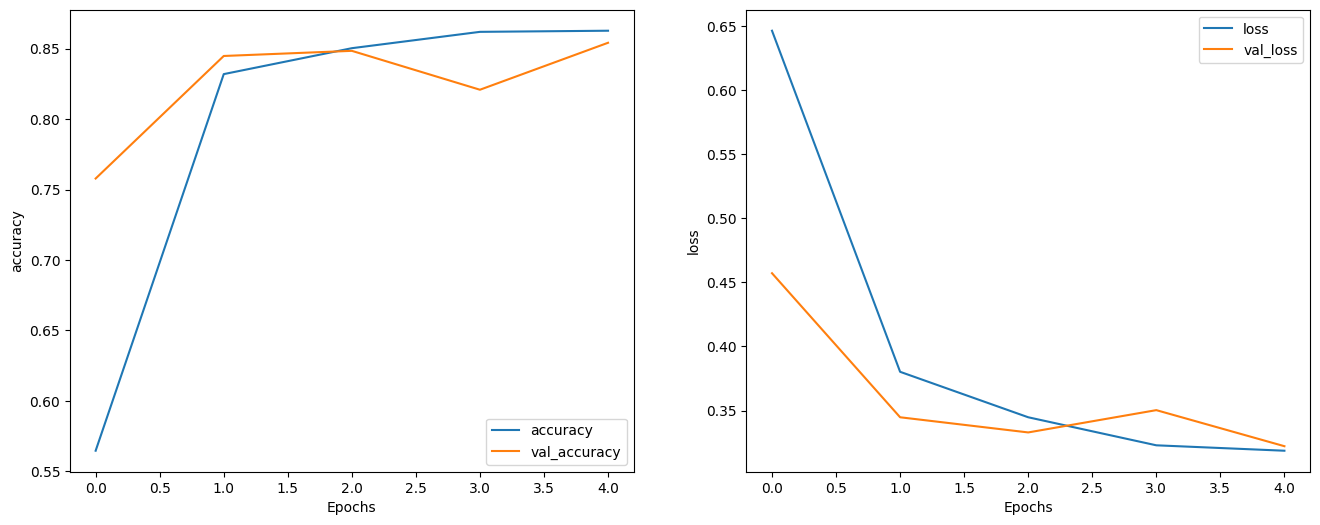

In [47]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

####分析一下您提供的模型训练损失（Loss）和准确率（Accuracy）图像。

图像信息分析：


* 训练损失 (loss - 蓝线): 随着训练轮数（Epochs）的增加，训练损失持续下降，从最初的约 0.65 降低到第 4 轮的约 0.32。这表明模型在训练数据上的拟合程度越来越好，学习到了训练数据的特征。
* 验证损失 (val_loss - 橙线): 验证损失在最初的 2 轮训练中迅速下降（从约 0.46 降至约 0.33），但在第 2 轮之后，验证损失趋于平缓，甚至在第 3 轮略有上升（约 0.35），之后又略微下降。
* 对比: 在第 1 轮之后，训练损失持续下降，但验证损失在第 2 轮达到最低点后不再显著下降，甚至有反弹趋势。训练损失和验证损失之间的差距（Gap）从第 1 轮开始出现并逐渐稳定。
####准确率（Accuracy）图像：:

* 训练准确率 (accuracy - 蓝线): 训练准确率随着训练轮数增加而显著提高，尤其是在第一轮，之后增速放缓，最终达到约 0.86。这与训练损失下降的趋势一致。
* 验证准确率 (val_accuracy - 橙线): 验证准确率也在前 2 轮快速提升（从约 0.76 升至约 0.85），但在第 2 轮达到峰值后，在第 3 轮有所下降（约 0.82），然后在第 4 轮又回升至约 0.855。
* 对比: 训练准确率持续上升，而验证准确率在第 2 轮达到高点后出现波动，并且略低于训练准确率。
####结论:

综合损失和准确率图像来看：

* 模型在训练初期学习效果显著，损失快速下降，准确率快速提升。
大约在 第 2 轮（Epoch 2） 左右，模型在验证集上的表现达到最佳（验证损失最低，验证准确率最高）。
* 在第 2 轮之后，训练损失继续下降，训练准确率继续上升，但验证损失不再下降（甚至略有上升），验证准确率也出现波动且不再显著提升。这是 过拟合（Overfitting） 的典型迹象。模型开始过度学习训练数据中的噪声或特定模式，导致其在未见过的验证数据上的泛化能力下降或停滞。
####如何优化模型:

针对观察到的过拟合现象，可以尝试以下优化策略：

* 早停（Early Stopping）: 这是最直接的方法。根据图像，模型在第 2 轮左右验证效果最好。可以在训练过程中监控验证损失（val_loss）或验证准确率（val_accuracy），当验证指标不再改善或开始变差时，提前停止训练，并保存此时的模型权重。

* 正则化（Regularization）:

* L1/L2 正则化: 在模型的损失函数中加入权重的 L1 或 L2 范数惩罚项，可以限制模型复杂度，降低权重值，从而减轻过拟合。
Dropout: 在训练过程中，随机将一部分神经元的输出设置为零。这强制网络学习更鲁棒的特征，减少神经元之间的协同适应，提高泛化能力。可以在全连接层或卷积层之后添加 Dropout 层。
* 数据增强（Data Augmentation）: 如果是图像、文本等数据，可以通过旋转、翻转、缩放、裁剪、改变亮度/对比度、添加噪声等方法扩充训练数据集。增加数据的多样性可以帮助模型学习到更具泛化性的特征。

* 减少模型复杂度: 如果模型过于复杂（层数过多、每层神经元过多），可以尝试简化模型结构，减少参数量，使其与数据量和任务难度更匹配。

* 获取更多数据: 如果条件允许，增加训练数据的数量和多样性是提高模型泛化能力、对抗过拟合最有效的方法之一。

* 调整学习率（Learning Rate）: 虽然当前图像主要指示过拟合，但有时调整学习率（例如，使用学习率衰减策略）也可能帮助模型找到更好的泛化点。

* 批归一化（Batch Normalization）: 虽然主要作用是加速训练和稳定训练过程，但它有时也能起到轻微的正则化效果。

####建议步骤:

首先尝试 早停，根据验证损失或验证准确率在第 2 轮左右停止训练。
如果早停后的性能仍不满意，可以尝试加入 Dropout 层或 L2 正则化。
如果数据允许，实施 数据增强。
如果上述方法效果有限，再考虑 简化模型结构 或 获取更多数据。
选择哪种或哪几种优化方法取决于具体的任务、数据和模型架构。通常需要进行实验来找到最有效的组合。

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
